# Before Start
### install packages numpy pandas scipy scikit-learn statsmodels geomstats matplotlib seaborn by
> !pip install numpy pandas scipy scikit-learn statsmodels geomstats matplotlib seaborn 

# Best Model by full quadratic and then backward selection

In [7]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import scipy.stats as st
from dataclasses import dataclass
from typing import Dict, List, Tuple, Optional
from itertools import product
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.patches import Patch

# ============================================================
# 0) Utility: safe transforms
# ============================================================
def safe_log(x, eps=1e-12):
    x = np.asarray(x, float)
    return np.log(np.maximum(x, eps))

def logit(u, eps=1e-6):
    u = np.asarray(u, float)
    u = np.clip(u, eps, 1 - eps)
    return np.log(u / (1 - u))

def safe_exp(z, clip=20.0):
    # exp(20) ~ 4.85e8 (large but finite), prevents overflow
    z = np.asarray(z, float)
    z = np.clip(z, -clip, clip)
    return np.exp(z)

def rmse(y_true: np.ndarray, y_pred: np.ndarray) -> float:
    r = y_true - y_pred
    return float(np.sqrt(np.mean(r * r)))

# ============================================================
# 1) Transformer objects
#    - identity: x
#    - log: log(x)
#    - logit: logit( (x-a)/(b-a) )
#    - exponential: exp( (x-mu)/sd )  [standardize then exp]
# ============================================================
@dataclass
class Transformer:
    name: str
    params: Optional[Tuple[float, float]] = None   # for logit: (min,max) ; for exp: (mu, sd)

    def forward(self, x: np.ndarray) -> np.ndarray:
        x = np.asarray(x, float)

        if self.name == "identity":
            return x

        if self.name == "log":
            return safe_log(x)

        if self.name == "logit":
            # min-max scale to (0,1) then logit
            if self.params is None:
                raise ValueError("logit transformer needs params=(min,max).")
            a, b = self.params
            u = (x - a) / (b - a + 1e-12)
            return logit(u)

        if self.name == "exponential":
            # standardize then exp to avoid exploding
            if self.params is None:
                raise ValueError("exponential transformer needs params=(mu,sd).")
            mu, sd = self.params
            z = (x - mu) / (sd + 1e-12)
            return safe_exp(z)

        raise ValueError(f"Unknown transformer: {self.name}")


def make_transformer(x: np.ndarray, method: str) -> Transformer:
    x = np.asarray(x, float)

    if method == "identity":
        return Transformer("identity", None)

    if method == "log":
        # log assumes positive; safe_log handles eps but interpretation matters
        return Transformer("log", None)

    if method == "logit":
        a = float(np.min(x))
        b = float(np.max(x))
        # if degenerate, fallback
        if abs(b - a) < 1e-12:
            return Transformer("identity", None)
        return Transformer("logit", (a, b))

    if method == "exponential":
        mu = float(np.mean(x))
        sd = float(np.std(x, ddof=1))
        # degenerate fallback
        if sd < 1e-12:
            return Transformer("identity", None)
        return Transformer("exponential", (mu, sd))

    raise ValueError(f"Unknown transform method: {method}")


# ============================================================
# 2) FULL QUADRATIC builder: const + (linear,square) + pairwise interactions
#    variables order fixed: ["c","k","kappa"]
# ============================================================
def build_full_quadratic(values: Dict[str, np.ndarray], var_order: List[str]) -> Tuple[np.ndarray, List[str]]:
    cols = [np.ones_like(values[var_order[0]])]
    names = ["const"]

    # linear + square
    for v in var_order:
        cols.append(values[v])
        names.append(v)
        cols.append(values[v] ** 2)
        names.append(f"{v}^2")

    # pairwise interactions
    for i in range(len(var_order)):
        for j in range(i+1, len(var_order)):
            vi, vj = var_order[i], var_order[j]
            cols.append(values[vi] * values[vj])
            names.append(f"{vi}:{vj}")

    X = np.column_stack(cols)
    return X, names


# ============================================================
# 3) Model selection over transform combinations (4^3 = 64)
# ============================================================

class SelectedModel:
    '''
    transform_choice: Dict[str, str]
    transformers: Dict[str, Transformer]
    full_feature_names: List[str]
    kept_feature_mask: np.ndarray
    kept_feature_names: List[str]
    fit: sm.regression.linear_model.RegressionResultsWrapper
    aic: float
    r2: float
    adj_r2: float
    n: int
    p: int
    df_resid: int
    '''
    def __init__(self,**kwargs):
        self.model = {}
        for k,v in kwargs.items():
            self.model[k] = v

def var_select(df,use_x_var,y_var):
    base = {
        use_x_var[i]: df[use_x_var[i]].to_numpy(float) for i in range(len(use_x_var))
    }

    y = df[y_var].to_numpy(float)
    return base, y
    
def select_model_full_transform_grid(df: pd.DataFrame,
                            transform_methods=("identity","log","logit"),
                            var_order=("c","k","kappa"),
                            y_col='RE',
                            verbose_top=5) -> SelectedModel:
    """
    For each (Tc, Tk, Tkappa and more) in n transform methods:
      - apply transforms
      - build FULL QUADRATIC
      - BACKWARD(AIC) with mandatory linear terms
      - record final AIC
    Pick best AIC.
    """

    # raw variables
    base, y = var_select(df,var_order,y_col)

    candidates = []
    methods = list(transform_methods)

    grid = {k:methods for k in var_order}
    combinations = list(product(*grid.values()))
    keys = grid.keys()
    
    # # 3. 단 하나의 for문으로 그리드 서치 수행
    for values in combinations:
        # 각 조합을 딕셔너리 형태로 매핑
        choice = dict(zip(keys, values))
            
        # build transformers using data-driven params
        trans = {v: make_transformer(base[v], choice[v]) for v in var_order}

        # transform data
        values = {v: trans[v].forward(base[v]) for v in var_order}

        # full quadratic design
        X_full, names_full = build_full_quadratic(values, list(var_order))

        # # mandatory = const + linear terms of c,k,kappa (after transform)
        # mandatory = ["const"] + list(var_order)

        # # backward(AIC)
        # keep_mask, fit_final = backward_selection_aic(y, X_full, names_full, mandatory)

        # X_kept = X_full[:, keep_mask]
        # kept_names = [nm for nm, kk in zip(names_full, keep_mask) if kk]

        # # refit to get consistent stats
        # fit = sm.OLS(y, X_kept).fit()

        fit = sm.OLS(y, X_full).fit()

        candidates.append({
            "transform_choice": choice,
            "transformers": trans,
            "full_feature_names": names_full,
            "X_full": X_full,
            # "kept_feature_mask": keep_mask,
            # "kept_feature_names": kept_names,
            "fit": fit,
            "AIC": float(fit.aic),
            "R2": float(fit.rsquared),
            "adj_R2": float(fit.rsquared_adj),
            "n": len(y),
            "p": len(names_full),
            "df_resid": int(fit.df_resid),
        })

    # sort by AIC
    candidates_sorted = sorted(candidates, key=lambda d: d["AIC"])

    # print top results
    print("\n=== Transform-grid : Top models by AIC ===")
    for i, cand in enumerate(candidates_sorted[:verbose_top]):
        ch = cand["transform_choice"]
        transforms_str = {var_order[k]:ch[var_order[k]] for k in range(len(var_order))}
        print(f"[{i+1:02d}] AIC={cand['AIC']:.6f}, AdjR2={cand['adj_R2']:.6f}, p={cand['p']}, "
              f"transforms: {transforms_str} ")
              # f"transforms: {var_order[0]}={ch[var_order[0]]}, {var_order[1]}={ch[var_order[1]]}, {var_order[2]}={ch[var_order[2]]}")

    best_ix = 0
    best = candidates_sorted[best_ix]
    subbest = candidates_sorted[best_ix+1]
    while ((best['adj_R2'] - subbest['adj_R2']) < 0.005):
        if (subbest["transform_choice"]["kappa"]=='identity'):
            best = subbest
            break
        else:
            best_ix += 1
            subbest = candidates_sorted[best_ix+1]
            
    return SelectedModel(**best)


# ============================================================
# 4) BACKWARD(AIC) with mandatory main effects
#    - mandatory: const + linear(c,k,kappa) must stay
# ============================================================
def backward_selection_aic(y: np.ndarray,
                           X_full: np.ndarray,
                           names_full: List[str],
                           mandatory_names: List[str]) -> Tuple[np.ndarray, sm.regression.linear_model.RegressionResultsWrapper]:

    keep = np.ones(len(names_full), dtype=bool)
    mandatory_idx = set(names_full.index(m) for m in mandatory_names)

    def fit_current(keep_mask):
        Xc = X_full[:, keep_mask]
        return sm.OLS(y, Xc).fit()

    fit = fit_current(keep)

    improved = True
    while improved:
        improved = False
        best_aic = float(fit.aic)
        best_drop = None

        for j in range(len(names_full)):
            if not keep[j]:
                continue
            if j in mandatory_idx:
                continue

            keep_try = keep.copy()
            keep_try[j] = False
            fit_try = fit_current(keep_try)
            aic_try = float(fit_try.aic)
            if aic_try < best_aic - 1e-10:
                best_aic = aic_try
                best_drop = j

        if best_drop is not None:
            keep[best_drop] = False
            fit = fit_current(keep)
            improved = True

    return keep, fit
    

def backward_selection_for_fixed_transform(selected_model, df, var_order=("c","k","kappa"), y_col='RE'):
    # mandatory = const + linear terms of c,k,kappa (after transform)
    mandatory = ["const"] + list(var_order)

    _, y = var_select(df,var_order,y_col)
    names_full = selected_model["full_feature_names"]
    
    # backward(AIC)
    keep_mask, fit_final = backward_selection_aic(
        y, selected_model["X_full"], selected_model["full_feature_names"], mandatory)

    X_kept = selected_model["X_full"][:, keep_mask]
    kept_names = [nm for nm, kk in zip(names_full, keep_mask) if kk]

    # refit to get consistent stats
    fit = sm.OLS(y, X_kept).fit()
    resid = y - fit.predict(X_kept)
    rss = float(np.sum(resid**2))
    mse = float(rss / fit.df_resid)
    
    return SelectedModel(**{
        "transform_choice": selected_model['transform_choice'],
        "transformers": selected_model["transformers"],
        "full_feature_names": names_full,
        "kept_feature_mask": keep_mask,
        "kept_feature_names": kept_names,
        "fit": fit,
        "resid": resid,
        "XtXinv": np.linalg.inv(X_kept.T @ X_kept),
        "t_critical_95": float(st.t.ppf(0.975, fit.df_resid)),
        "AIC": float(fit.aic),
        "R2": float(fit.rsquared),
        "adj_R2": float(fit.rsquared_adj),
        "mse": mse,
        "RMSE": float(np.sqrt(mse)),
        "n": int(X_kept.shape[0]),
        "p": int(X_kept.shape[1]),
        "df_resid": int(fit.df_resid),
    }).model


# ============================================================
# 5) Beta table + Model summary printing
# ============================================================

def X_transformed_name(p, mapping):
    # ^를 기준으로 분리 (c^2 -> base='c', exp='2')
    base, *exp = p.split('^')
    func = mapping.get(base, 'identity')
    
    if func == 'identity': return p
    # 제곱항이 있으면 (func base)^exp, 없으면 func base
    return f"({func} {base})^{exp[0]}" if exp else f"{func} {base}"
    
def print_beta_and_summary(best, label):
    
    print(f"\n================ {label} ================")
    print({k:v for k,v in best.items() if k in ['n','p','df_resid']})
    print({k:round(v,6) for k,v  in best.items() if k in ['R2','adj_R2','AIC','RMSE']})
    print({k:round(v,10) for k,v in best.items() if k in ['MSE','t_critical_95']})
    #print(f"R2={best.r2:.6f}, AdjR2={best.adj_r2:.6f}, AIC={best.aic:.6f}, RMSE={best.rmse:.6f}")
    #print(f"MSE={best.mse:.10g}, sigma={best.sigma:.10g}, tcrit(0.975)={best.tcrit:.10g}")
    
    terms = [":".join(X_transformed_name(p,best["transform_choice"]) for p in col.split(':')) for col in best["kept_feature_names"]]
    robust = best["fit"].get_robustcov_results()
    
    # OLS coefficients
    coef = pd.DataFrame({
        "parameter":[f'$β_{i}$' for i in range(len(terms))],
        "term": terms,
        "beta": best["fit"].params,
        "SE": robust.bse,
        "p-value": robust.pvalues
    })
    print("\n[Beta table: OLS beta + SE/p]")
    print(coef.to_string(index=False))
    return coef


# ============================================================
# 7) Cutoff table for 95% RE(point, supremum, infinum)
# ============================================================

def invert_threshold(x_grid: np.ndarray, f_vals: np.ndarray, target: float) -> Optional[float]:
    """
    Find minimal x such that f(x) >= target, using linear interpolation on grid.
    Return None if never reaches target.
    """
    idx = np.where(f_vals >= target)[0]
    if len(idx) == 0:
        return None
    j = int(idx[0])
    if j == 0:
        return float(x_grid[0])
    x0, x1 = float(x_grid[j - 1]), float(x_grid[j])
    y0, y1 = float(f_vals[j - 1]), float(f_vals[j])
    if y1 == y0:
        return x1
    return float(x0 + (target - y0) * (x1 - x0) / (y1 - y0))


def fmt_cut(v: Optional[float], x_min: float, x_max: float) -> str:
    if v is None:
        return f">{x_max:.3f}"
    if abs(v - x_min) < 1e-12:
        return f"≤{x_min:.3f}"
    return f"{v:.3f}"

def Xg_for(model, target_grid_transformed, target_col, fixed_inputs: dict) -> np.ndarray:
    
    cols = []
    for c in model['kept_feature_names']:
        c1 = np.ones_like(target_grid_transformed)
        if c != 'const':
            for p in c.split(':'):
                base, *exp = p.split('^')
                func = model["transform_choice"].get(base, 'identity')
                if base == target_col:
                    transformed_value = target_grid_transformed
                else:
                    if func == 'identity':
                        transformed_value = np.full_like(target_grid_transformed,fixed_inputs[base])
                    else:
                        transformed_value = np.full_like(
                            target_grid_transformed, model['transformers'][base].forward(fixed_inputs[base])
                        )
                if exp:
                    c1 *= transformed_value**float(exp[0])
                else:
                    c1 *= transformed_value
        cols.append(c1) 
    # # if best includes extra term, add it
    # if "1/sqrt(k)" in best.terms:
    #     cols.append(np.full_like(logc, 1.0/np.sqrt(k_val)))
    # if "1/k" in best.terms:
    #     cols.append(np.full_like(logc, 1.0/k_val))
    # if "log(1+1/k)" in best.terms:
    #     cols.append(np.full_like(logc, np.log(1.0 + 1.0/k_val)))
    # if "log(c)/sqrt(k)" in best.terms:
    #     cols.append(logc/np.sqrt(k_val))
    return np.column_stack(cols)

def cutoff_table(best: SelectedModel, df: pd.DataFrame, target: float = 0.95,
                   target_col: str = "c",
                   eff_list: List[int] = [1,2,5,10,20,50,100],
                   kappa_list: List[Tuple[str,float]] = [("Euclidean",0.0),("Sphere",1.0),("Hyperbolic",-1.0)],
                   grid_extrapolate = False,
                   ci_or_pi = 'pi'
                  ) -> pd.DataFrame:
    """
    For Model A/B: invert over c-grid.
    """
    x_min = float(df[target_col].min())
    x_max = float(df[target_col].max())
    extrapolate_grid = (x_max-x_min)*0.5 if grid_extrapolate else 0
    grid = np.linspace(x_min-extrapolate_grid, x_max+extrapolate_grid, 20000)
    target_grid_transformed = best['transformers'][target_col].forward(grid)
    
    rows = []
    for k_eff in eff_list:
        row = {"k_eff": k_eff}
        for name, kap_val in kappa_list:
            Xg = Xg_for(best, target_grid_transformed, target_col, {'k':k_eff, 'kappa':kap_val})
            mu = Xg @ best["fit"].params
            h = np.sum((Xg @ best["XtXinv"]) * Xg, axis=1)
            if ci_or_pi == 'pi':
                se_pred = np.sqrt(best["mse"] * (1.0 + h))
            else:
                se_pred = np.sqrt(best["mse"] * (h))
            lo = mu - best["t_critical_95"] * se_pred
            hi = mu + best["t_critical_95"] * se_pred

            point = invert_threshold(grid, mu, target)
            upper = invert_threshold(grid, hi, target)
            lower = invert_threshold(grid, lo, target)
            # row[name] = f"{fmt_cut(point, x_min, x_max)} [{fmt_cut(upper, x_min, x_max)}, {fmt_cut(lower, x_min, x_max)}]"
            row[name] = f"{point:.3f} [{upper:.3f}, {lower:.3f}]"
        rows.append(row)

    return pd.DataFrame(rows)

# ============================================================
# 8) Draw 2 by 3 panel charts of RE vs Cutoff
# ============================================================
def draw_panels(best: SelectedModel, df: pd.DataFrame, out_png: str = None, target: float = 0.95,
                  target_col: str = "c", y_col: str = "RE", xlabel: str = "Cutoff", ci_or_pi = 'pi'
                 ):
    """
    Model A panel: x-axis = cutoff_ratio, y-axis = RE
    2x3 panels: k_eff = [1,2,5,10,50,100]
    """
    k_panels = [1,2,5,10,50,100]
    manifolds = [("Sphere",1.0),("Euclidean",0.0),("Hyperbolic",-1.0)]
    colors = {"Sphere":"C0","Euclidean":"C1","Hyperbolic":"C2"}

    x_min = float(df[target_col].min())
    x_max = float(df[target_col].max())
    extrapolate_grid = 0
    grid = np.linspace(x_min-extrapolate_grid, x_max+extrapolate_grid, 20000)
    target_grid_transformed = best['transformers'][target_col].forward(grid)

    fig, axes = plt.subplots(2, 3, figsize=(10, 6), sharey=True)
    axes = axes.ravel()

    for j, k_eff in enumerate(k_panels):
        ax = axes[j]
        ax.set_title(rf"$k_{{\mathrm{{eff}}}}(\Sigma)={k_eff}$", fontsize=10)

        for mlabel, kap_val in manifolds:
            sub = df[(df["k"] == k_eff) & (df["kappa"] == kap_val)]
            if len(sub):
                ax.scatter(sub[target_col], sub[y_col], s=12, alpha=0.5, color=colors[mlabel])

            Xg = Xg_for(best, target_grid_transformed, target_col, {'k':k_eff, 'kappa':kap_val})
            mu = Xg @ best["fit"].params
            h = np.sum((Xg @ best["XtXinv"]) * Xg, axis=1)
            if ci_or_pi=='pi':
                se_pred = np.sqrt(best["mse"] * (1.0 + h))
            else:
                se_pred = np.sqrt(best["mse"] * (h))
            lo = mu - best["t_critical_95"] * se_pred
            hi = mu + best["t_critical_95"] * se_pred
            

            ax.plot(grid, mu, color=colors[mlabel], linewidth=1.8)
            ax.fill_between(grid, lo, hi, color=colors[mlabel], alpha=0.18)
            ax.plot(grid, lo, color=colors[mlabel], linestyle="--", linewidth=1.0)
            ax.plot(grid, hi, color=colors[mlabel], linestyle="--", linewidth=1.0)

        ax.axhline(target, color="red", linestyle=":", linewidth=1.2)
        ax.axhline(1.0, color="black", linestyle=":", linewidth=1.2)
        extra_lim = (x_max-x_min)*0.02
        ax.set_xlim(x_min-extra_lim, x_max+extra_lim)
        ax.set_ylim(0.85, 1.05)
        ax.set_xlabel(xlabel)

    axes[0].set_ylabel("Relative Efficiency")
    axes[3].set_ylabel("Relative Efficiency")

    # Legend placed near the last (6th) panel
    
    handles = []
    for mlabel, _ in manifolds:
        handles += [
            Line2D([0],[0], color=colors[mlabel], marker='o', linestyle='None', markersize=5, alpha=0.5, label=f"{mlabel} data"),
            Line2D([0],[0], color=colors[mlabel], linestyle='-', linewidth=1.8, label=f"{mlabel} fit"),
            Patch(facecolor=colors[mlabel], alpha=0.18, label=f"{mlabel} 95% PI"),
        ]
    handles += [
        Line2D([0],[0], color="red", linestyle=":", linewidth=1.2, label=f"RE = {target:.2f}"),
        Line2D([0],[0], color="black", linestyle=":", linewidth=1.2, label="RE = 1.00"),
    ]

    bbox = axes[2].get_position()
    legend_x = bbox.x1 - 0.03
    legend_y = bbox.y1 + 0.07 #(bbox.y0 + bbox.y1) / 2
    fig.legend(handles=handles, loc="upper left", bbox_to_anchor=(legend_x, legend_y), frameon=True, fontsize=9)

    fig.tight_layout(rect=[0,0,0.88,1])
    if out_png is not None:
        plt.savefig(out_png, dpi=200, bbox_inches="tight")
        plt.close(fig)
    else:
        plt.show()


In [16]:
     
# ============================================================
# 6) Example runner
# ============================================================
if __name__ == "__main__":
    csv_path = "regression_cutoff_agg/regtable_hardr_gaussian_rev.csv"  #_change_d10_lowrank.csv"
    df = pd.read_csv(csv_path)
    column_name_mapper = {'cutoff_ratio':'c','ptile':'p','eff_rank':'k','curvature':'kappa'}
    df.columns = [column_name_mapper[c] if c in column_name_mapper else c for c in df.columns]
    df = df.loc[df['RE'].notnull()].reset_index(drop=True)
    
    best_transform_grid_A = select_model_full_transform_grid(
        df, transform_methods=("identity","log","logit","exponential"),
        var_order=("c","k","kappa"),
        verbose_top=5)
    best_A = backward_selection_for_fixed_transform(
        selected_model=best_transform_grid_A.model, df=df, var_order=("c","k","kappa")) #,"k","kappa"))

    print("\n=== BEST MODEL (by AIC) ===")
    print("Transforms:", best_A["transform_choice"])
    print("Selected terms:", best_A["kept_feature_names"])
    print_beta_and_summary(best_A, label='BEST MODEL by AIC [A:Cutoff Ratio]')

    best_transform_grid_B = select_model_full_transform_grid(
        df, transform_methods=("identity","log","logit"),  #,"exponential"  
        var_order=("p","k","kappa"),
        verbose_top=5)
    best_B = backward_selection_for_fixed_transform(
        selected_model=best_transform_grid_B.model, df=df, var_order=("p","k","kappa")) #,"k","kappa"))

    print("\n=== BEST MODEL (by AIC) ===")
    print("Transforms:", best_B["transform_choice"])
    print("Selected terms:", best_B["kept_feature_names"])
    print_beta_and_summary(best_B, label='BEST MODEL by AIC [B:Cutoff Percentile]')




=== Transform-grid : Top models by AIC ===
[01] AIC=-6338.479448, AdjR2=0.861797, p=10, transforms: {'c': 'log', 'k': 'log', 'kappa': 'logit'} 
[02] AIC=-6338.479448, AdjR2=0.861797, p=10, transforms: {'c': 'log', 'k': 'log', 'kappa': 'identity'} 
[03] AIC=-6336.376106, AdjR2=0.861490, p=10, transforms: {'c': 'log', 'k': 'log', 'kappa': 'exponential'} 
[04] AIC=-6336.116654, AdjR2=0.861307, p=10, transforms: {'c': 'log', 'k': 'log', 'kappa': 'log'} 
[05] AIC=-6242.696705, AdjR2=0.847087, p=10, transforms: {'c': 'identity', 'k': 'log', 'kappa': 'logit'} 

=== BEST MODEL (by AIC) ===
Transforms: {'c': 'log', 'k': 'log', 'kappa': 'identity'}
Selected terms: ['const', 'c', 'c^2', 'k', 'k^2', 'kappa', 'c:k', 'k:kappa']

================ BEST MODEL by AIC [A:Cutoff Ratio] ================
{'n': 947, 'p': 8, 'df_resid': 939}
{'AIC': -6341.584126, 'R2': 0.862982, 'adj_R2': 0.861961, 'RMSE': 0.008469}
{'t_critical_95': 1.9624935692}

[Beta table: OLS beta + SE/p]
parameter        term      bet

In [17]:
cutoff_table(best=best_A, df=df, target = 0.95,
                   target_col = "c",
                   eff_list = [1,2,5,10,20,50,100],
                   kappa_list = [("Euclidean",0.0),("Sphere",1.0),("Hyperbolic",-1.0)],
                 ci_or_pi = 'ci'
                  )

,k_eff,Euclidean,Sphere,Hyperbolic
0,1,"1.319 [1.298, 1.341]","1.329 [1.301, 1.358]","1.310 [1.284, 1.336]"
1,2,"1.081 [1.068, 1.094]","1.086 [1.069, 1.103]","1.076 [1.060, 1.093]"
2,5,"0.838 [0.829, 0.847]","0.838 [0.828, 0.849]","0.838 [0.827, 0.848]"
3,10,"0.696 [0.685, 0.706]","0.694 [0.682, 0.705]","0.698 [0.686, 0.708]"
4,20,"0.627 [0.627, 0.627]","0.627 [0.627, 0.627]","0.627 [0.627, 0.627]"
5,50,"0.627 [0.627, 0.627]","0.627 [0.627, 0.627]","0.627 [0.627, 0.627]"
6,100,"0.627 [0.627, 0.627]","0.627 [0.627, 0.627]","0.627 [0.627, 0.627]"


In [18]:
cutoff_table(best=best_B, df=df, target = 0.95,
             target_col="p",
             eff_list=[1,2,5,10,20,50,100],
             kappa_list=[("Euclidean",0.0),("Sphere",1.0),("Hyperbolic",-1.0)],
             grid_extrapolate=True
            )

,k_eff,Euclidean,Sphere,Hyperbolic
0,1,"78.322 [61.623, 94.490]","78.120 [61.401, 94.306]","78.524 [61.817, 94.700]"
1,2,"62.964 [42.688, 82.304]","62.721 [42.414, 82.087]","63.208 [42.926, 82.553]"
2,5,"36.629 [7.373, 63.223]","36.287 [6.963, 62.930]","36.970 [7.731, 63.558]"
3,10,"5.277 [-42.365, 43.725]","4.759 [-42.365, 43.318]","5.793 [-42.365, 44.192]"
4,20,"-42.365 [-42.365, 10.267]","-42.365 [-42.365, 9.544]","-42.365 [-42.365, 11.092]"
5,50,"-42.365 [-42.365, -42.365]","-42.365 [-42.365, -42.365]","-42.365 [-42.365, -42.365]"
6,100,"-42.365 [-42.365, -42.365]","-42.365 [-42.365, -42.365]","-42.365 [-42.365, -42.365]"


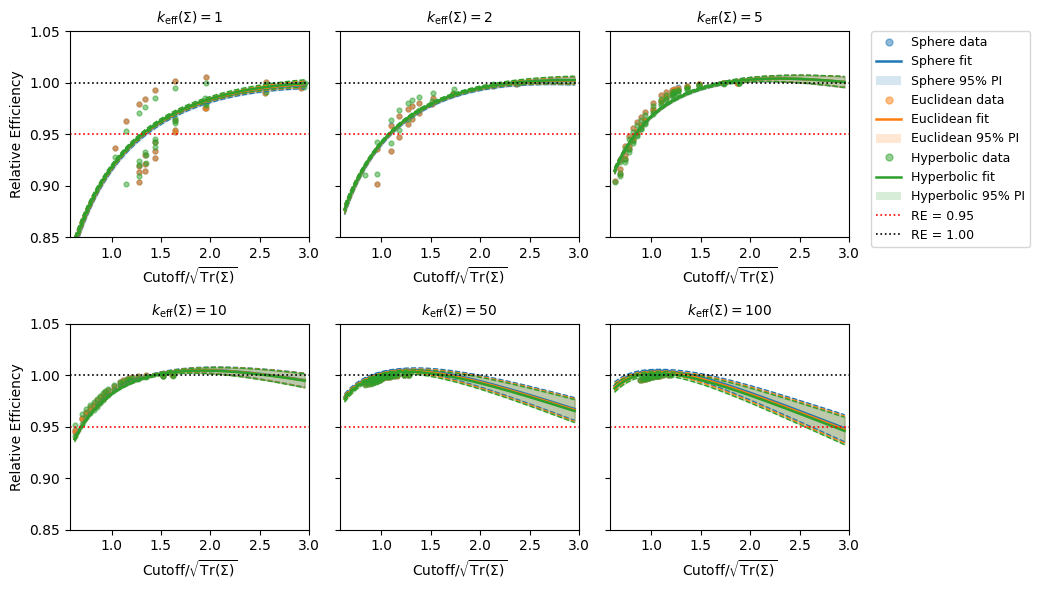

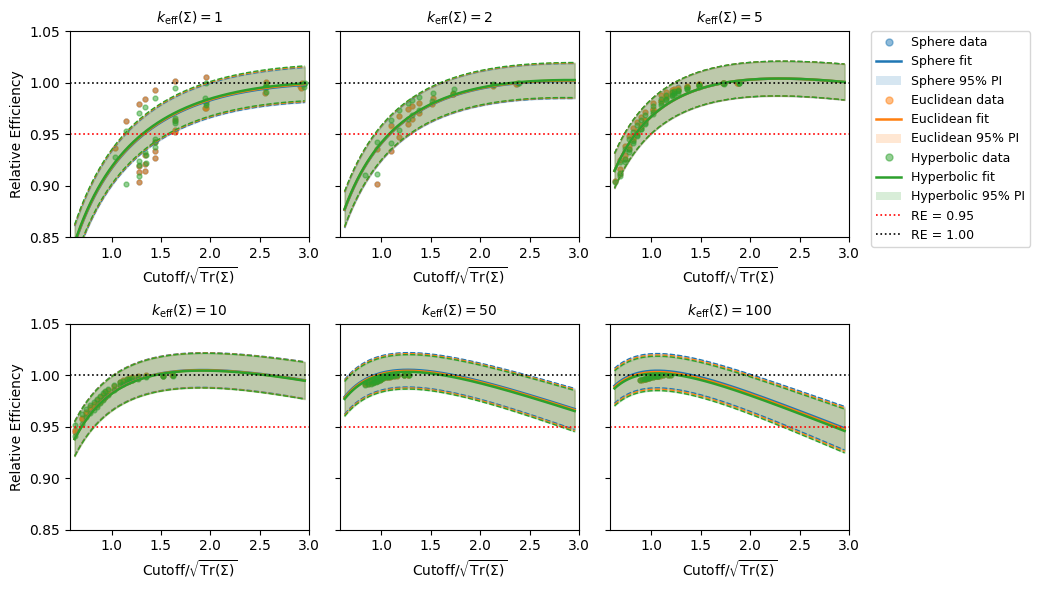

In [19]:
draw_panels(best_A, df, out_png=None, target=0.95,
            target_col="c", y_col="RE",
            xlabel= r"Cutoff/$\sqrt{\mathrm{Tr}(\Sigma)}$", #"Cutoff Percentile(%)"
            ci_or_pi='ci'
                 )

draw_panels(best_A, df, out_png=None, target=0.95,
            target_col="c", y_col="RE",
            xlabel= r"Cutoff/$\sqrt{\mathrm{Tr}(\Sigma)}$", #"Cutoff Percentile(%)"
            ci_or_pi='pi'
                 )


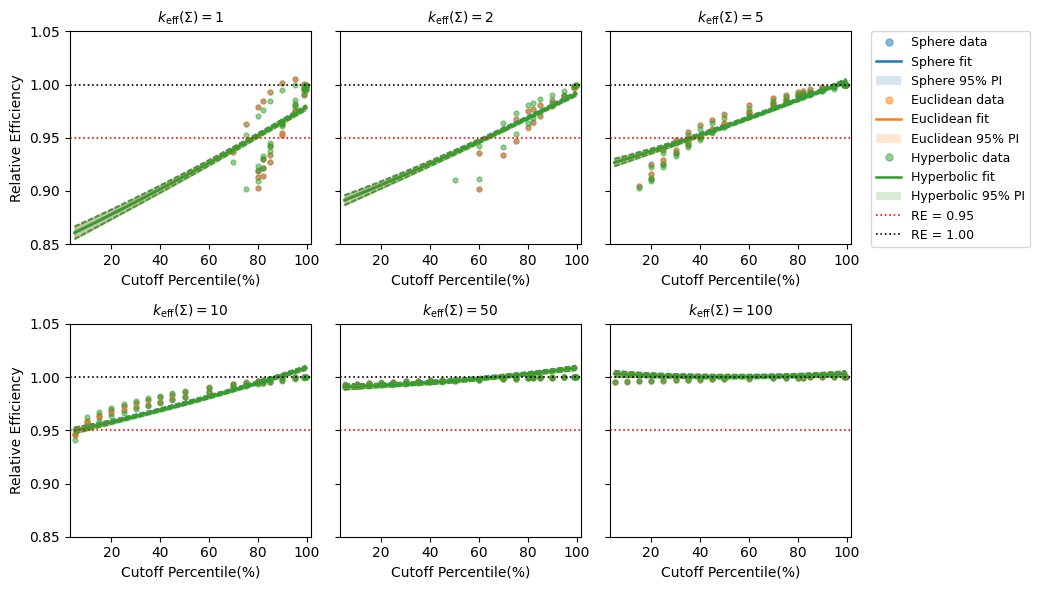

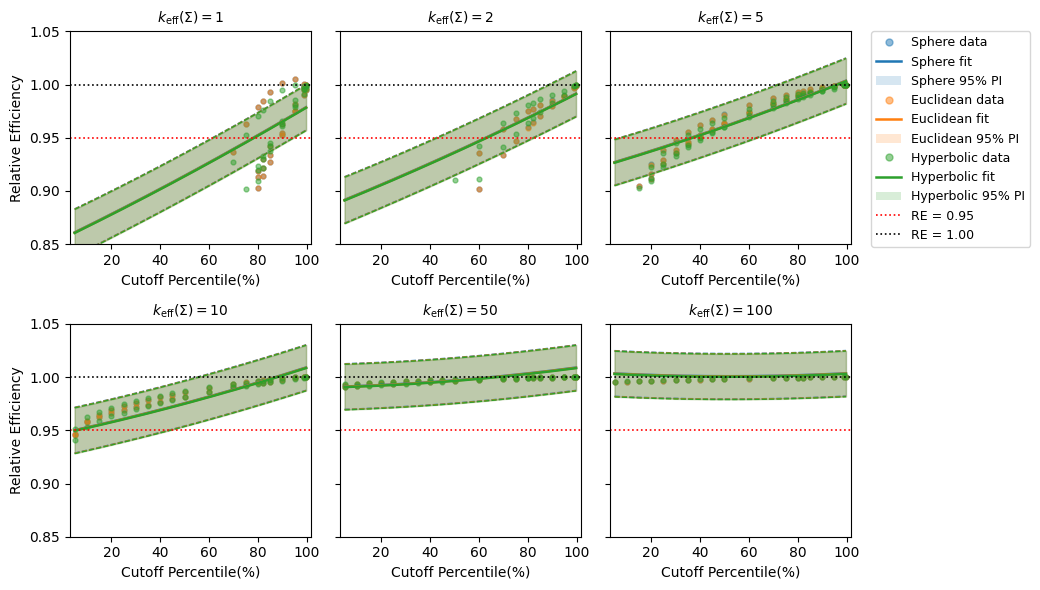

In [20]:
draw_panels(best_B, df, out_png=None, target=0.95,
            target_col="p", y_col="RE",
            xlabel= "Cutoff Percentile(%)", #
            ci_or_pi='ci'
                 )

draw_panels(best_B, df, out_png=None, target=0.95,
            target_col="p", y_col="RE",
            xlabel= "Cutoff Percentile(%)",
            ci_or_pi='pi'
                 )
